In [1]:
import pandas as pd
import numpy as np

In [2]:
"""
This function loads the dataset from the csv files
"""
def load_dataset():
    train_df = pd.read_csv("../Data/UNSW_NB15_testing-set.csv")
    test_df = pd.read_csv("../Data/UNSW_NB15_training-set.csv")
    return train_df, test_df

In [3]:
"""
This function preprocesses the attack_cat column
"""
def data_preprocessing_attack_cat(data):
    data["attack_cat"] = data["attack_cat"].fillna('Normal')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Fuzzers ','Fuzzers')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Reconnaissance ','Reconnaissance')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace(' Shellcode ','Shellcode')
    data["attack_cat"] = data["attack_cat"].replace('Backdoors','Backdoor')
    return data

In [4]:
"""
This function visualizes the attack categories
"""
def visualize_attack_cats(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))
    sns.countplot(x="attack_cat", data=data)
    plt.show()

In [5]:
"""
This function preprocesses the numerical columns
"""
def preprocess_numerical_cols(df):
    numerical_cols = df.select_dtypes(exclude=["object"]).columns
    df[numerical_cols] = df[numerical_cols].fillna(0)
    return df

In [6]:
"""
This function preprocesses the categorical columns
"""
def preprocess_categorical_cols(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    categorical_cols = list(categorical_cols)
    categorical_cols.remove("attack_cat")
    df[categorical_cols] = df[categorical_cols].replace('-', "None")
    df[categorical_cols] = df[categorical_cols].fillna("None")
    return df

In [7]:
"""
This function preprocesses the data
"""
def preprocess_data(df):
    df = preprocess_numerical_cols(df)
    df = preprocess_categorical_cols(df)
    return df

In [8]:
"""
This function One Hot Encodes the column
"""
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode_fit_col(data, col):
    values = data[col].unique()
    for index, v_col in enumerate(values):
        values[index] = col+"_"+v_col
        data[col+"_"+v_col] = np.zeros(len(data))
    enc = OneHotEncoder(handle_unknown='ignore')
    data[values] = enc.fit_transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data, enc, values

In [9]:
"""
This function One Hot Encodes the column
"""
def one_hot_encode_transform_col(data, col, enc, col_values):
    for v_col in col_values:
        data[v_col] = np.zeros(len(data))
    data[col_values] = enc.transform(data[col].values.reshape(-1,1)).toarray()
    data = data.drop([col],axis=1)
    return data

In [10]:
"""
This function Label Encodes the column
"""
def label_encoder_fit_col(data, col):
    values = ["out"]
    values.extend(data[col].unique())
    dict_values = {k: v for v, k in enumerate(values)}
    #print(dict_values)
    data[col] = data[col].apply(lambda x: dict_values[x])
    data[col] = data[col].astype("int32")
    return data, dict_values

In [11]:
"""
This function Label Encodes the column
"""
def label_encoder_transform_col(data, col, dict_values):
    data[col] = data[col].apply(lambda x: dict_values[x] if x in dict_values else 0)
    data[col] = data[col].astype("int32")
    return data

In [12]:
"""
This function gets the class weights
"""
from sklearn.utils import class_weight
def get_class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced',
                                                     classes=np.unique(y),
                                                     y=y)
    class_weights = {k: v for k,v in enumerate(class_weights)}
    return class_weights

In [13]:
"""
This function Label Encodes the column
"""
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
def label_encode(y,num_classes):
    cls_label_encoder = LabelEncoder()
    y = cls_label_encoder.fit_transform(y)
    y = to_categorical(y, num_classes=num_classes)
    return y, cls_label_encoder

In [52]:
"""
This function is used to print the scores
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score, f1_score
def print_score(y_pred, y_real,cls_label_encoder):
    print("Accuracy: ", accuracy_score(y_real, y_pred))
    print ("Precision Score: ", precision_score(y_real, y_pred, average='weighted'))
    print ("Recall Score: ", recall_score(y_real, y_pred, average='weighted'))
    print ("F1 Score: ", f1_score(y_real, y_pred, average='weighted'))
    print("Confusion Matrix")
    print(confusion_matrix(y_real, y_pred))


In [15]:
"""
This function calculates the f1 score
"""
import keras.backend as K
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [16]:
"""
This function calculates the f1 score
"""
from sklearn.preprocessing import MinMaxScaler
def min_max_scaler_fit_col(data):
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(data)
    return data

In [17]:
train_df,test_df = load_dataset()

In [18]:
train_df = train_df.drop(["id"], axis=1)
test_df = test_df.drop(["id"], axis=1)

In [19]:
train_df = data_preprocessing_attack_cat(train_df)
test_df = data_preprocessing_attack_cat(test_df)

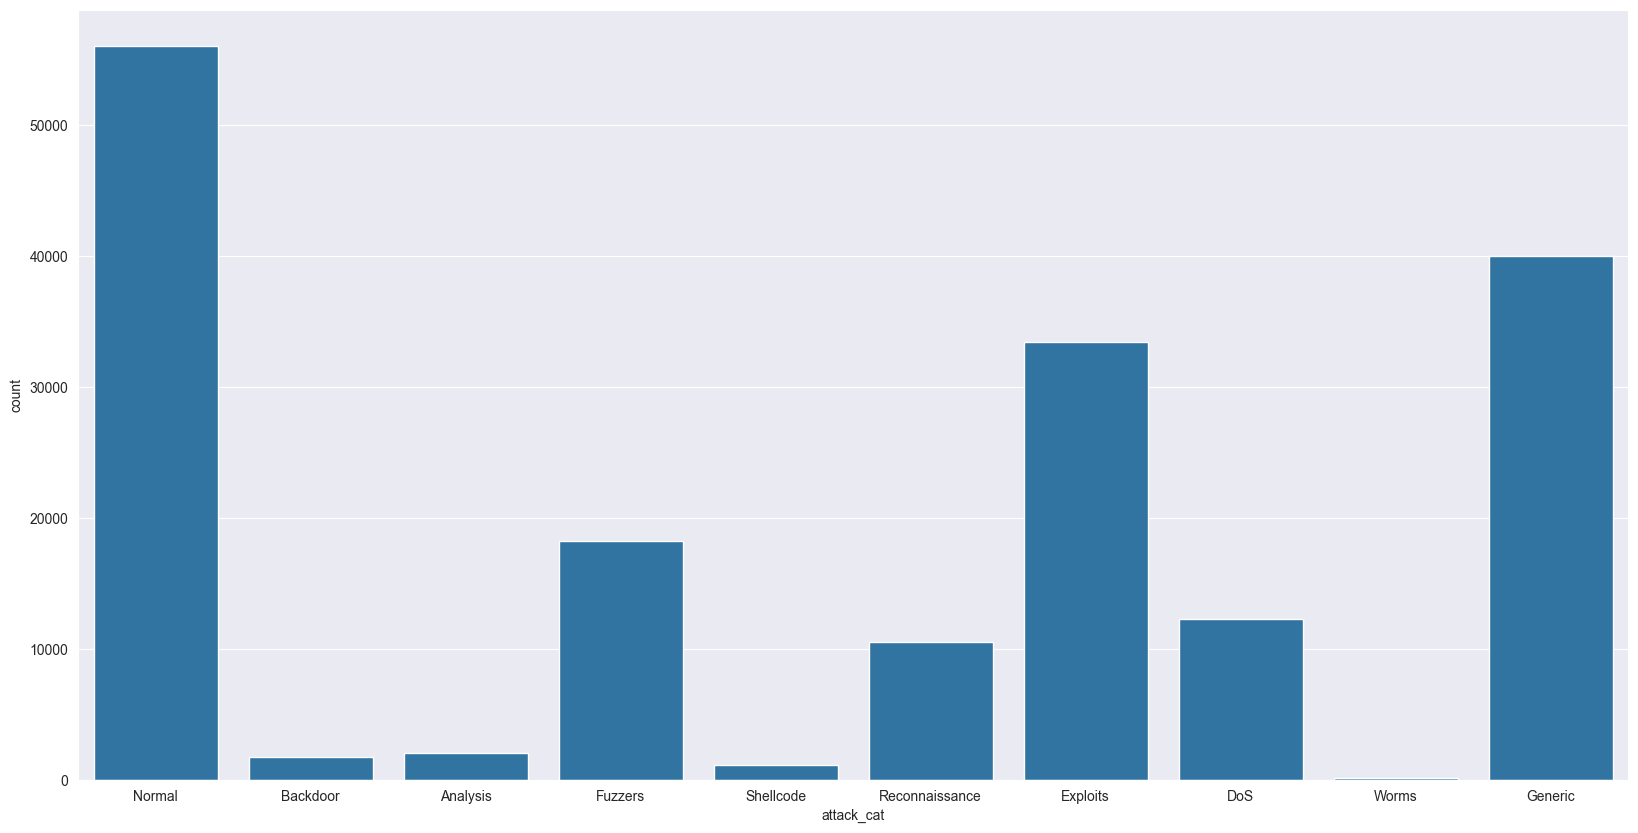

In [20]:
visualize_attack_cats(train_df)

In [21]:
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [22]:
train_df, dict_values = label_encoder_fit_col(train_df, "proto")
test_df = label_encoder_transform_col(test_df, "proto", dict_values)

In [23]:
train_df, dict_values = label_encoder_fit_col(train_df, "service")
test_df = label_encoder_transform_col(test_df, "service", dict_values)

In [24]:
train_df, dict_values = label_encoder_fit_col(train_df, "state")
test_df = label_encoder_transform_col(test_df, "state", dict_values)

In [25]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [26]:
X_train = train_df.drop(["label", "attack_cat"], axis=1)
y_train = train_df["attack_cat"]
X_test = test_df.drop(["label", "attack_cat"], axis=1)
y_test = test_df["attack_cat"]

In [27]:
X_train = min_max_scaler_fit_col(X_train)
X_test = min_max_scaler_fit_col(X_test)

In [28]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [29]:
class_weights = get_class_weights(y_train)

In [30]:
y_train, cls_label_encoder = label_encode(y_train, len(np.unique(y_train)))
y_test, _ = label_encode(y_test, len(np.unique(y_test)))

In [31]:
cls_label_encoder.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [32]:
print(y_train.shape)
print(y_test.shape)

(175341, 10)
(82332, 10)


In [33]:
print(X_train.shape)
print(X_test.shape)

(175341, 42, 1)
(82332, 42, 1)


In [34]:
"""
This function creates the GRU model
"""
from keras.layers import Dense, GRU, Dropout, BatchNormalization
from keras.models import Sequential
def create_GRU_model(input_shape, n_classes):
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [35]:
input_shape = X_train.shape[1:]

In [49]:
from sklearn.model_selection import ParameterSampler
import tensorflow as tf
def tune_hyperparams():
    # use random serch to tune hyperparameters
    params_grid = {
        'batch_size': [32, 64, 128],
        'epochs': [10, 20, 30],
        'learning_rate': [0.0001, 0.001, 0.01],
        'dropout_rate': [0.2, 0.25, 0.3],
        'activation': ['relu', 'leaky_relu', 'tan_h'],
        'optimizer': ['adam', 'sgd', 'rmsprop']
    }
    params_list = list(ParameterSampler(params_grid, n_iter=10, random_state=42))
    best_params = None
    for params in params_list:
        print("Trying Out : ",params)
        model =  create_GRU_model(input_shape, 10)
        if params['optimizer'] == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        elif params['optimizer'] == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                  validation_split=0.2, class_weight=class_weights)
        _, accuracy = model.evaluate(X_test, y_test)
        if best_params is None or accuracy > best_params['accuracy']:
            best_params = {'accuracy': accuracy, 'params': params}
    print("Best Params : ", best_params)

In [ ]:
# tune_hyperparams()

In [36]:
gru_clf = create_GRU_model(input_shape,10)

In [37]:
from tensorflow.keras.metrics import Recall, Precision
import tensorflow.keras as keras
gru_clf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='binary_crossentropy', 
                 metrics=['accuracy', Precision(), Recall(), f1_score])

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_weights_file_path = "gru_mul_clf.h5"
checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_accuracy",
                             verbose=1, save_best_only=True, mode="max", save_weights_only=True)
early_stopping = EarlyStopping(monitor="val_accuracy", mode="max", verbose=1, patience=20,restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, 
                              verbose=1, mode='max', min_delta=0.0001, cooldown=0, min_lr=0)

call_backs = [checkpoint, early_stopping, lr_reduce]

In [39]:
gru_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 42, 256)           198912    
                                                                 
 dropout (Dropout)           (None, 42, 256)           0         
                                                                 
 batch_normalization (Batch  (None, 42, 256)           1024      
 Normalization)                                                  
                                                                 
 gru_1 (GRU)                 (None, 42, 128)           148224    
                                                                 
 dropout_1 (Dropout)         (None, 42, 128)           0         
                                                                 
 batch_normalization_1 (Bat  (None, 42, 128)           512       
 chNormalization)                                       

In [40]:
EPOCHS = 50
BATCH_SIZE = 128
history_clf = gru_clf.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
             validation_split=0.2, class_weight=class_weights, callbacks=call_backs)

Epoch 1/50
1096/1096 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.4776 - precision: 0.8968 - recall: 0.3801 - f1_score: 0.5240
Epoch 1: val_accuracy improved from -inf to 0.29696, saving model to gru_mul_clf.h5
1096/1096 [==============================] - 136s 119ms/step - loss: 0.2650 - accuracy: 0.4776 - precision: 0.8968 - recall: 0.3801 - f1_score: 0.5240 - val_loss: 0.3708 - val_accuracy: 0.2970 - val_precision: 0.5382 - val_recall: 0.2832 - val_f1_score: 0.3705 - lr: 0.0050
Epoch 2/50
1096/1096 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.5059 - precision: 0.8496 - recall: 0.4081 - f1_score: 0.5470
Epoch 2: val_accuracy improved from 0.29696 to 0.53734, saving model to gru_mul_clf.h5
1096/1096 [==============================] - 129s 118ms/step - loss: 0.2318 - accuracy: 0.5059 - precision: 0.8496 - recall: 0.4081 - f1_score: 0.5470 - val_loss: 0.1685 - val_accuracy: 0.5373 - val_precision: 0.8651 - val_recall: 0.4515 - val_f1_

In [41]:
"""
This function evaluates the model
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
def evaluate_Test(model, X_test, y_test, cls_label_encoder):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print_score(y_hat, y_true, cls_label_encoder)

In [42]:
"""
This function visualizes the loss
"""
def visualize_loss(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [43]:
"""
This function visualizes the accuracy
"""
def visualize_accuracy(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

In [44]:
"""
This function plots the confusion matrix
"""
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test)
    y_hat = np.argmax(y_hat, axis=1)
    y_true = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true, y_hat)
    plt.figure(figsize=(20,10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=cls_label_encoder.classes_, yticklabels=cls_label_encoder.classes_)
    plt.show()
   
    

In [53]:
evaluate_Test(gru_clf, X_test, y_test, cls_label_encoder)

2573/2573 [==============================] - 70s 27ms/step
Accuracy:  0.5761915172715347
Precision Score:  0.7993629031270699
Recall Score:  0.5761915172715347
F1 Score:  0.6404560517945371
Confusion Matrix
[[    0    10   602    29     7     0    27     0     2     0]
 [    0    17   497    10    12     0     2     1    40     4]
 [   13   190  2637   530    90     4    25    48   386   166]
 [  163   199  2878  5016   400    13    92    18  1164  1189]
 [    0    70  1178     1  3799     0    46     7   706   255]
 [ 1781     1    42   297    60 16066    17    36   290   281]
 [ 1292    68    28  1719 10828     4 19548     4  3343   166]
 [    3    34   283     4   406     1     5     7  2282   471]
 [    0     0     0     0    63     0     0     0   315     0]
 [    0     0     0     0     3     0     0     0     7    34]]


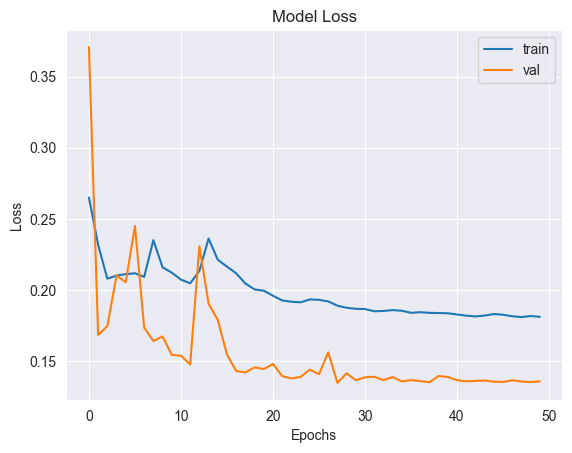

In [46]:
visualize_loss(history_clf)

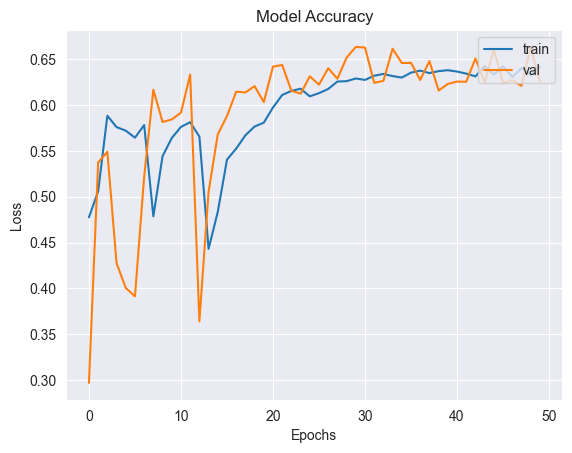

In [47]:
visualize_accuracy(history_clf)

2573/2573 [==============================] - 39s 15ms/step


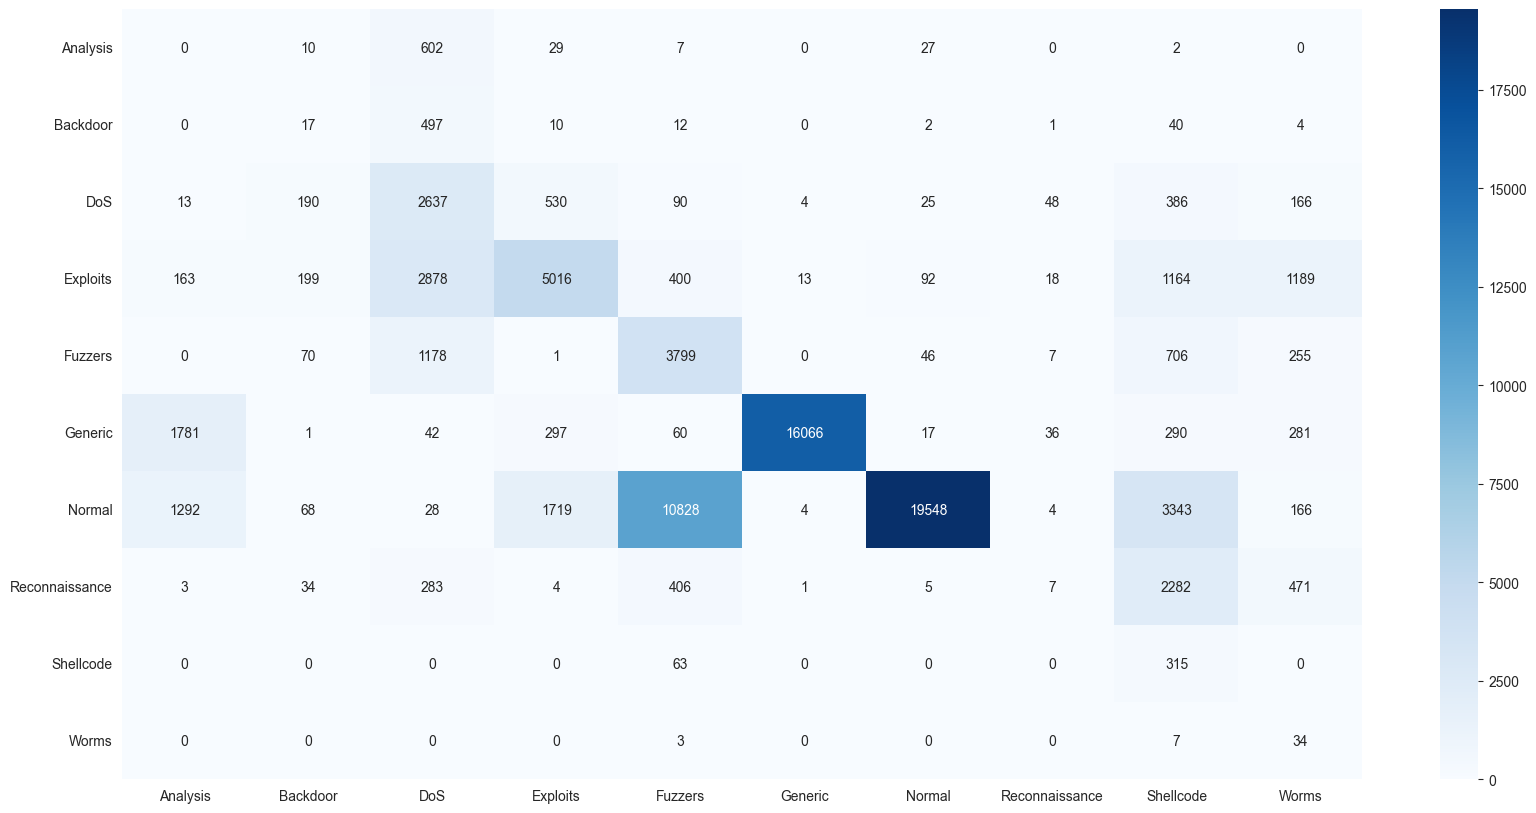

In [48]:
plot_confusion_matrix(gru_clf, X_test, y_test)